In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_A"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 11169
Total validation images: 2898
Total test images: 3627
Total images in dataset: 17694


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 9928
Validation images (excluding 'random_occlusion'): 2576
Test images (excluding 'random_occlusion'): 3224
Total images (excluding 'random_occlusion'): 15728


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'chromatic_aberration', 'blur', 'random_occlusion', 'original', 'low_resolution', 'dirty_lens', 'motion_blur', 'gaussian_noise', 'lens_flare'}
Validation folders considered: {'chromatic_aberration', 'blur', 'random_occlusion', 'original', 'low_resolution', 'dirty_lens', 'motion_blur', 'gaussian_noise', 'lens_flare'}
Test folders considered: {'chromatic_aberration', 'blur', 'random_occlusion', 'original', 'low_resolution', 'dirty_lens', 'motion_blur', 'gaussian_noise', 'lens_flare'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']
Final Training images: 9928
Final Validation images: 2576
Final Test images: 3224
Total images after filtering: 15728


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'chromatic_aberration', 'blur', 'original', 'low_resolution', 'dirty_lens', 'motion_blur', 'gaussian_noise', 'lens_flare'}
Validation folders considered: {'chromatic_aberration', 'blur', 'original', 'low_resolution', 'dirty_lens', 'motion_blur', 'gaussian_noise', 'lens_flare'}
Test folders considered: {'chromatic_aberration', 'blur', 'original', 'low_resolution', 'dirty_lens', 'motion_blur', 'gaussian_noise', 'lens_flare'}


In [7]:
# -----------------------------
# 2. Define InceptionNetV3 Model from Scratch (CORRECTED)
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time

class BasicConv2d(nn.Module):
    """Basic convolution block: Conv2d + BatchNorm + ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                             stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class InceptionA(nn.Module):
    """Inception-A block (35x35 grid)"""
    def __init__(self, in_channels, pool_features):
        super().__init__()
        # Branch 1: 1x1 conv
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)
        
        # Branch 2: 1x1 conv -> 5x5 conv
        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)
        
        # Branch 3: 1x1 conv -> 3x3 conv -> 3x3 conv
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)
        
        # Branch 4: avg pool -> 1x1 conv
        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

class InceptionB(nn.Module):
    """Inception-B block (17x17 grid)"""
    def __init__(self, in_channels):
        super().__init__()
        # Branch 1: 1x1 conv
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)
        
        # Branch 2: 1x1 conv -> 1x7 conv -> 7x1 conv
        self.branch7x7_1 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(128, 128, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(128, 192, kernel_size=(7, 1), padding=(3, 0))
        
        # Branch 3: 1x1 conv -> 7x1 conv -> 1x7 conv -> 7x1 conv -> 1x7 conv
        self.branch7x7dbl_1 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(128, 128, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(128, 128, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(128, 128, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(128, 192, kernel_size=(1, 7), padding=(0, 3))
        
        # Branch 4: avg pool -> 1x1 conv
        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)
        
        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)

class InceptionC(nn.Module):
    """Inception-C block (8x8 grid)"""
    def __init__(self, in_channels):
        super().__init__()
        # Branch 1: 1x1 conv
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)
        
        # Branch 2: 1x1 conv -> split into 1x3 and 3x1 convs
        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))
        
        # Branch 3: 1x1 conv -> 3x3 conv -> split into 1x3 and 3x1 convs
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))
        
        # Branch 4: avg pool -> 1x1 conv
        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)
        
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

class ReductionA(nn.Module):
    """Reduction A block (35x35 to 17x17)"""
    def __init__(self, in_channels):
        super().__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)
        
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        
        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

class ReductionB(nn.Module):
    """Reduction B block (17x17 to 8x8)"""
    def __init__(self, in_channels):
        super().__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)
        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        
        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)
        
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)

class InceptionAux(nn.Module):
    """Auxiliary classifier for InceptionV3"""
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.fc = nn.Linear(768, num_classes)
        
    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x num_classes
        return x

class MyInceptionNetV3(nn.Module):
    """InceptionNetV3 Implementation from Scratch"""
    def __init__(self, num_classes=4, aux_logits=True, transform_input=False):
        super().__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input
        
        # Initial convolution layers
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Inception blocks
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        
        # Reduction A (CORRECTED)
        self.Mixed_6a = ReductionA(288)
        
        self.Mixed_6b = InceptionB(768)
        self.Mixed_6c = InceptionB(768)
        self.Mixed_6d = InceptionB(768)
        self.Mixed_6e = InceptionB(768)
        
        # Auxiliary classifier
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes)
        
        # Reduction B (CORRECTED)
        self.Mixed_7a = ReductionB(768)
        
        self.Mixed_7b = InceptionC(1280)
        self.Mixed_7c = InceptionC(2048)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using appropriate methods"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        
        aux_logits = None
        if self.aux_logits and self.training:
            aux_logits = self.AuxLogits(x)
        
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x num_classes
        
        if self.aux_logits and self.training:
            return x, aux_logits
        return x

In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyInceptionNetV3(num_classes=len(classes), aux_logits=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("InceptionNetV3 Model Summary:")
# Note: Input size should be 299x299 for InceptionV3
try:
    summary(model, (3, 299, 299))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

InceptionNetV3 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
         


🚀 Starting InceptionNetV3 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [04:20<00:00,  1.19it/s, Loss=1.5406, Acc=0.5381, GPU=0.4GB]


✅ Training completed in 260.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:45<00:00,  1.78it/s, Loss=1.1643, Acc=0.5322]


✅ Validation completed in 45.44s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.5322

📊 Epoch 1 Summary:
│ Train Loss: 1.5406 | Train Acc: 0.5381
│ Val Loss:   1.1643 | Val Acc:   0.5322
│ Train Time: 260.95s | Val Time: 45.44s
│ Total Epoch Time: 306.39s
│ Best Val Acc: 0.5322 (Epoch 1)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=1.2360, Acc=0.6325, GPU=0.4GB]


✅ Training completed in 197.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.71it/s, Loss=0.8889, Acc=0.6281]


✅ Validation completed in 29.86s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.6281

📊 Epoch 2 Summary:
│ Train Loss: 1.2360 | Train Acc: 0.6325
│ Val Loss:   0.8889 | Val Acc:   0.6281
│ Train Time: 197.95s | Val Time: 29.86s
│ Total Epoch Time: 227.82s
│ Best Val Acc: 0.6281 (Epoch 2)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:21<00:00,  1.54it/s, Loss=0.9689, Acc=0.7170, GPU=0.4GB]


✅ Training completed in 201.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.83it/s, Loss=0.8964, Acc=0.6471]


✅ Validation completed in 28.63s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.6471

📊 Epoch 3 Summary:
│ Train Loss: 0.9689 | Train Acc: 0.7170
│ Val Loss:   0.8964 | Val Acc:   0.6471
│ Train Time: 201.42s | Val Time: 28.63s
│ Total Epoch Time: 230.05s
│ Best Val Acc: 0.6471 (Epoch 3)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:22<00:00,  1.53it/s, Loss=0.7500, Acc=0.7841, GPU=0.4GB]


✅ Training completed in 202.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.87it/s, Loss=0.7831, Acc=0.7003]


✅ Validation completed in 28.25s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.7003

📊 Epoch 4 Summary:
│ Train Loss: 0.7500 | Train Acc: 0.7841
│ Val Loss:   0.7831 | Val Acc:   0.7003
│ Train Time: 202.84s | Val Time: 28.25s
│ Total Epoch Time: 231.10s
│ Best Val Acc: 0.7003 (Epoch 4)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.58it/s, Loss=0.5290, Acc=0.8534, GPU=0.4GB]


✅ Training completed in 197.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.83it/s, Loss=1.0611, Acc=0.6661]


✅ Validation completed in 28.65s

📊 Epoch 5 Summary:
│ Train Loss: 0.5290 | Train Acc: 0.8534
│ Val Loss:   1.0611 | Val Acc:   0.6661
│ Train Time: 197.03s | Val Time: 28.65s
│ Total Epoch Time: 225.69s
│ Best Val Acc: 0.7003 (Epoch 4)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:22<00:00,  1.54it/s, Loss=0.3725, Acc=0.8934, GPU=0.4GB]


✅ Training completed in 202.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.72it/s, Loss=0.9023, Acc=0.7325]


✅ Validation completed in 29.76s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.7325

📊 Epoch 6 Summary:
│ Train Loss: 0.3725 | Train Acc: 0.8934
│ Val Loss:   0.9023 | Val Acc:   0.7325
│ Train Time: 202.46s | Val Time: 29.76s
│ Total Epoch Time: 232.23s
│ Best Val Acc: 0.7325 (Epoch 6)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:27<00:00,  1.50it/s, Loss=0.2656, Acc=0.9318, GPU=0.4GB]


✅ Training completed in 207.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.71it/s, Loss=1.3079, Acc=0.6964]


✅ Validation completed in 29.92s

📊 Epoch 7 Summary:
│ Train Loss: 0.2656 | Train Acc: 0.9318
│ Val Loss:   1.3079 | Val Acc:   0.6964
│ Train Time: 207.24s | Val Time: 29.92s
│ Total Epoch Time: 237.16s
│ Best Val Acc: 0.7325 (Epoch 6)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:26<00:00,  1.51it/s, Loss=0.2013, Acc=0.9453, GPU=0.4GB]


✅ Training completed in 206.48s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:33<00:00,  2.42it/s, Loss=1.1232, Acc=0.7236]


✅ Validation completed in 33.55s

📊 Epoch 8 Summary:
│ Train Loss: 0.2013 | Train Acc: 0.9453
│ Val Loss:   1.1232 | Val Acc:   0.7236
│ Train Time: 206.48s | Val Time: 33.55s
│ Total Epoch Time: 240.03s
│ Best Val Acc: 0.7325 (Epoch 6)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:36<00:00,  1.43it/s, Loss=0.1669, Acc=0.9546, GPU=0.4GB]


✅ Training completed in 216.93s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:33<00:00,  2.43it/s, Loss=1.1667, Acc=0.7352]


✅ Validation completed in 33.33s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.7352

📊 Epoch 9 Summary:
│ Train Loss: 0.1669 | Train Acc: 0.9546
│ Val Loss:   1.1667 | Val Acc:   0.7352
│ Train Time: 216.93s | Val Time: 33.33s
│ Total Epoch Time: 250.28s
│ Best Val Acc: 0.7352 (Epoch 9)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:35<00:00,  1.44it/s, Loss=0.1250, Acc=0.9676, GPU=0.4GB]


✅ Training completed in 215.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:31<00:00,  2.55it/s, Loss=1.1416, Acc=0.7228]


✅ Validation completed in 31.76s

📊 Epoch 10 Summary:
│ Train Loss: 0.1250 | Train Acc: 0.9676
│ Val Loss:   1.1416 | Val Acc:   0.7228
│ Train Time: 215.64s | Val Time: 31.76s
│ Total Epoch Time: 247.41s
│ Best Val Acc: 0.7352 (Epoch 9)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:27<00:00,  1.50it/s, Loss=0.0985, Acc=0.9726, GPU=0.4GB]


✅ Training completed in 207.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:31<00:00,  2.59it/s, Loss=1.3399, Acc=0.7193]


✅ Validation completed in 31.28s

📊 Epoch 11 Summary:
│ Train Loss: 0.0985 | Train Acc: 0.9726
│ Val Loss:   1.3399 | Val Acc:   0.7193
│ Train Time: 207.37s | Val Time: 31.28s
│ Total Epoch Time: 238.65s
│ Best Val Acc: 0.7352 (Epoch 9)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:26<00:00,  1.50it/s, Loss=0.0861, Acc=0.9755, GPU=0.4GB]


✅ Training completed in 206.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.74it/s, Loss=1.7703, Acc=0.7147]


✅ Validation completed in 29.58s

📊 Epoch 12 Summary:
│ Train Loss: 0.0861 | Train Acc: 0.9755
│ Val Loss:   1.7703 | Val Acc:   0.7147
│ Train Time: 206.82s | Val Time: 29.58s
│ Total Epoch Time: 236.41s
│ Best Val Acc: 0.7352 (Epoch 9)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:19<00:00,  1.56it/s, Loss=0.0897, Acc=0.9731, GPU=0.4GB]


✅ Training completed in 199.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.77it/s, Loss=1.1262, Acc=0.7566]


✅ Validation completed in 29.20s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.7566

📊 Epoch 13 Summary:
│ Train Loss: 0.0897 | Train Acc: 0.9731
│ Val Loss:   1.1262 | Val Acc:   0.7566
│ Train Time: 199.55s | Val Time: 29.20s
│ Total Epoch Time: 228.75s
│ Best Val Acc: 0.7566 (Epoch 13)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:19<00:00,  1.56it/s, Loss=0.0606, Acc=0.9848, GPU=0.4GB]


✅ Training completed in 199.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.89it/s, Loss=1.4531, Acc=0.7302]


✅ Validation completed in 28.07s

📊 Epoch 14 Summary:
│ Train Loss: 0.0606 | Train Acc: 0.9848
│ Val Loss:   1.4531 | Val Acc:   0.7302
│ Train Time: 199.29s | Val Time: 28.07s
│ Total Epoch Time: 227.36s
│ Best Val Acc: 0.7566 (Epoch 13)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.56it/s, Loss=0.0532, Acc=0.9865, GPU=0.4GB]


✅ Training completed in 198.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.89it/s, Loss=1.3170, Acc=0.7399]


✅ Validation completed in 28.03s

📊 Epoch 15 Summary:
│ Train Loss: 0.0532 | Train Acc: 0.9865
│ Val Loss:   1.3170 | Val Acc:   0.7399
│ Train Time: 198.92s | Val Time: 28.03s
│ Total Epoch Time: 226.95s
│ Best Val Acc: 0.7566 (Epoch 13)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:25<00:00,  1.51it/s, Loss=0.0867, Acc=0.9786, GPU=0.4GB]


✅ Training completed in 205.51s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.71it/s, Loss=1.2004, Acc=0.7484]


✅ Validation completed in 29.85s

📊 Epoch 16 Summary:
│ Train Loss: 0.0867 | Train Acc: 0.9786
│ Val Loss:   1.2004 | Val Acc:   0.7484
│ Train Time: 205.51s | Val Time: 29.85s
│ Total Epoch Time: 235.36s
│ Best Val Acc: 0.7566 (Epoch 13)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:20<00:00,  1.55it/s, Loss=0.0518, Acc=0.9886, GPU=0.4GB]


✅ Training completed in 200.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.86it/s, Loss=1.6357, Acc=0.7073]


✅ Validation completed in 28.29s

📊 Epoch 17 Summary:
│ Train Loss: 0.0518 | Train Acc: 0.9886
│ Val Loss:   1.6357 | Val Acc:   0.7073
│ Train Time: 200.23s | Val Time: 28.29s
│ Total Epoch Time: 228.53s
│ Best Val Acc: 0.7566 (Epoch 13)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=0.1125, Acc=0.9710, GPU=0.4GB]


✅ Training completed in 197.66s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.81it/s, Loss=1.1335, Acc=0.7593]


✅ Validation completed in 28.82s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.7593

📊 Epoch 18 Summary:
│ Train Loss: 0.1125 | Train Acc: 0.9710
│ Val Loss:   1.1335 | Val Acc:   0.7593
│ Train Time: 197.66s | Val Time: 28.82s
│ Total Epoch Time: 226.48s
│ Best Val Acc: 0.7593 (Epoch 18)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:21<00:00,  1.55it/s, Loss=0.0387, Acc=0.9907, GPU=0.4GB]


✅ Training completed in 201.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:31<00:00,  2.54it/s, Loss=1.4380, Acc=0.7481]


✅ Validation completed in 31.83s

📊 Epoch 19 Summary:
│ Train Loss: 0.0387 | Train Acc: 0.9907
│ Val Loss:   1.4380 | Val Acc:   0.7481
│ Train Time: 201.07s | Val Time: 31.83s
│ Total Epoch Time: 232.91s
│ Best Val Acc: 0.7593 (Epoch 18)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.57it/s, Loss=0.0567, Acc=0.9854, GPU=0.4GB]


✅ Training completed in 198.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.85it/s, Loss=1.2667, Acc=0.7504]


✅ Validation completed in 28.46s

📊 Epoch 20 Summary:
│ Train Loss: 0.0567 | Train Acc: 0.9854
│ Val Loss:   1.2667 | Val Acc:   0.7504
│ Train Time: 198.33s | Val Time: 28.46s
│ Total Epoch Time: 226.80s
│ Best Val Acc: 0.7593 (Epoch 18)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:19<00:00,  1.56it/s, Loss=0.0514, Acc=0.9874, GPU=0.4GB]


✅ Training completed in 199.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:31<00:00,  2.60it/s, Loss=1.3284, Acc=0.7492]


✅ Validation completed in 31.14s

📊 Epoch 21 Summary:
│ Train Loss: 0.0514 | Train Acc: 0.9874
│ Val Loss:   1.3284 | Val Acc:   0.7492
│ Train Time: 199.40s | Val Time: 31.14s
│ Total Epoch Time: 230.55s
│ Best Val Acc: 0.7593 (Epoch 18)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:20<00:00,  1.55it/s, Loss=0.0568, Acc=0.9833, GPU=0.4GB]


✅ Training completed in 200.60s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.84it/s, Loss=1.5181, Acc=0.7465]


✅ Validation completed in 28.49s

📊 Epoch 22 Summary:
│ Train Loss: 0.0568 | Train Acc: 0.9833
│ Val Loss:   1.5181 | Val Acc:   0.7465
│ Train Time: 200.60s | Val Time: 28.49s
│ Total Epoch Time: 229.09s
│ Best Val Acc: 0.7593 (Epoch 18)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:21<00:00,  1.55it/s, Loss=0.0329, Acc=0.9919, GPU=0.4GB]


✅ Training completed in 201.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.85it/s, Loss=1.4891, Acc=0.7469]


✅ Validation completed in 28.40s

📊 Epoch 23 Summary:
│ Train Loss: 0.0329 | Train Acc: 0.9919
│ Val Loss:   1.4891 | Val Acc:   0.7469
│ Train Time: 201.21s | Val Time: 28.40s
│ Total Epoch Time: 229.61s
│ Best Val Acc: 0.7593 (Epoch 18)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:16<00:00,  1.58it/s, Loss=0.0612, Acc=0.9844, GPU=0.4GB]


✅ Training completed in 196.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.82it/s, Loss=1.1848, Acc=0.7582]


✅ Validation completed in 28.70s

📊 Epoch 24 Summary:
│ Train Loss: 0.0612 | Train Acc: 0.9844
│ Val Loss:   1.1848 | Val Acc:   0.7582
│ Train Time: 196.64s | Val Time: 28.70s
│ Total Epoch Time: 225.35s
│ Best Val Acc: 0.7593 (Epoch 18)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.57it/s, Loss=0.0201, Acc=0.9949, GPU=0.4GB]


✅ Training completed in 198.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.88it/s, Loss=1.4010, Acc=0.7620]


✅ Validation completed in 28.12s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.7620

📊 Epoch 25 Summary:
│ Train Loss: 0.0201 | Train Acc: 0.9949
│ Val Loss:   1.4010 | Val Acc:   0.7620
│ Train Time: 198.43s | Val Time: 28.12s
│ Total Epoch Time: 226.55s
│ Best Val Acc: 0.7620 (Epoch 25)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=0.0437, Acc=0.9886, GPU=0.4GB]


✅ Training completed in 197.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.86it/s, Loss=1.3244, Acc=0.7578]


✅ Validation completed in 28.30s

📊 Epoch 26 Summary:
│ Train Loss: 0.0437 | Train Acc: 0.9886
│ Val Loss:   1.3244 | Val Acc:   0.7578
│ Train Time: 197.80s | Val Time: 28.30s
│ Total Epoch Time: 226.10s
│ Best Val Acc: 0.7620 (Epoch 25)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:19<00:00,  1.56it/s, Loss=0.0328, Acc=0.9927, GPU=0.4GB]


✅ Training completed in 199.36s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.76it/s, Loss=1.3636, Acc=0.7500]


✅ Validation completed in 29.37s

📊 Epoch 27 Summary:
│ Train Loss: 0.0328 | Train Acc: 0.9927
│ Val Loss:   1.3636 | Val Acc:   0.7500
│ Train Time: 199.36s | Val Time: 29.37s
│ Total Epoch Time: 228.73s
│ Best Val Acc: 0.7620 (Epoch 25)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.56it/s, Loss=0.0756, Acc=0.9819, GPU=0.4GB]


✅ Training completed in 198.75s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.84it/s, Loss=1.2727, Acc=0.7477]


✅ Validation completed in 28.51s

📊 Epoch 28 Summary:
│ Train Loss: 0.0756 | Train Acc: 0.9819
│ Val Loss:   1.2727 | Val Acc:   0.7477
│ Train Time: 198.75s | Val Time: 28.51s
│ Total Epoch Time: 227.26s
│ Best Val Acc: 0.7620 (Epoch 25)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.56it/s, Loss=0.0322, Acc=0.9945, GPU=0.4GB]


✅ Training completed in 198.75s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.82it/s, Loss=1.4551, Acc=0.7768]


✅ Validation completed in 28.68s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.7768

📊 Epoch 29 Summary:
│ Train Loss: 0.0322 | Train Acc: 0.9945
│ Val Loss:   1.4551 | Val Acc:   0.7768
│ Train Time: 198.75s | Val Time: 28.68s
│ Total Epoch Time: 227.44s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:19<00:00,  1.56it/s, Loss=0.0897, Acc=0.9761, GPU=0.4GB]


✅ Training completed in 199.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.87it/s, Loss=1.2451, Acc=0.7582]


✅ Validation completed in 28.27s

📊 Epoch 30 Summary:
│ Train Loss: 0.0897 | Train Acc: 0.9761
│ Val Loss:   1.2451 | Val Acc:   0.7582
│ Train Time: 199.25s | Val Time: 28.27s
│ Total Epoch Time: 227.52s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:22<00:00,  1.54it/s, Loss=0.0153, Acc=0.9960, GPU=0.4GB]


✅ Training completed in 202.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:31<00:00,  2.60it/s, Loss=1.4376, Acc=0.7632]


✅ Validation completed in 31.21s

📊 Epoch 31 Summary:
│ Train Loss: 0.0153 | Train Acc: 0.9960
│ Val Loss:   1.4376 | Val Acc:   0.7632
│ Train Time: 202.32s | Val Time: 31.21s
│ Total Epoch Time: 233.53s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.56it/s, Loss=0.0237, Acc=0.9938, GPU=0.4GB]


✅ Training completed in 198.83s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.83it/s, Loss=1.6984, Acc=0.7151]


✅ Validation completed in 28.65s

📊 Epoch 32 Summary:
│ Train Loss: 0.0237 | Train Acc: 0.9938
│ Val Loss:   1.6984 | Val Acc:   0.7151
│ Train Time: 198.83s | Val Time: 28.65s
│ Total Epoch Time: 227.49s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.57it/s, Loss=0.0544, Acc=0.9878, GPU=0.4GB]


✅ Training completed in 198.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.85it/s, Loss=1.2902, Acc=0.7508]


✅ Validation completed in 28.44s

📊 Epoch 33 Summary:
│ Train Loss: 0.0544 | Train Acc: 0.9878
│ Val Loss:   1.2902 | Val Acc:   0.7508
│ Train Time: 198.23s | Val Time: 28.44s
│ Total Epoch Time: 226.67s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=0.0104, Acc=0.9972, GPU=0.4GB]


✅ Training completed in 197.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.79it/s, Loss=1.3186, Acc=0.7624]


✅ Validation completed in 29.02s

📊 Epoch 34 Summary:
│ Train Loss: 0.0104 | Train Acc: 0.9972
│ Val Loss:   1.3186 | Val Acc:   0.7624
│ Train Time: 197.95s | Val Time: 29.02s
│ Total Epoch Time: 226.97s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:22<00:00,  1.54it/s, Loss=0.0104, Acc=0.9977, GPU=0.4GB]


✅ Training completed in 202.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.84it/s, Loss=1.4189, Acc=0.7620]


✅ Validation completed in 28.55s

📊 Epoch 35 Summary:
│ Train Loss: 0.0104 | Train Acc: 0.9977
│ Val Loss:   1.4189 | Val Acc:   0.7620
│ Train Time: 202.34s | Val Time: 28.55s
│ Total Epoch Time: 230.89s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:20<00:00,  1.55it/s, Loss=0.0205, Acc=0.9946, GPU=0.4GB]


✅ Training completed in 200.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.85it/s, Loss=1.5885, Acc=0.7391]


✅ Validation completed in 28.45s

📊 Epoch 36 Summary:
│ Train Loss: 0.0205 | Train Acc: 0.9946
│ Val Loss:   1.5885 | Val Acc:   0.7391
│ Train Time: 200.33s | Val Time: 28.45s
│ Total Epoch Time: 228.79s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.57it/s, Loss=0.0622, Acc=0.9846, GPU=0.4GB]


✅ Training completed in 198.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.81it/s, Loss=1.4447, Acc=0.7554]


✅ Validation completed in 28.85s

📊 Epoch 37 Summary:
│ Train Loss: 0.0622 | Train Acc: 0.9846
│ Val Loss:   1.4447 | Val Acc:   0.7554
│ Train Time: 198.18s | Val Time: 28.85s
│ Total Epoch Time: 227.04s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=0.0187, Acc=0.9949, GPU=0.4GB]


✅ Training completed in 197.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.89it/s, Loss=1.3756, Acc=0.7380]


✅ Validation completed in 28.07s

📊 Epoch 38 Summary:
│ Train Loss: 0.0187 | Train Acc: 0.9949
│ Val Loss:   1.3756 | Val Acc:   0.7380
│ Train Time: 197.53s | Val Time: 28.07s
│ Total Epoch Time: 225.61s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:21<00:00,  1.54it/s, Loss=0.0382, Acc=0.9906, GPU=0.4GB]


✅ Training completed in 201.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.75it/s, Loss=1.5134, Acc=0.7492]


✅ Validation completed in 29.41s

📊 Epoch 39 Summary:
│ Train Loss: 0.0382 | Train Acc: 0.9906
│ Val Loss:   1.5134 | Val Acc:   0.7492
│ Train Time: 201.92s | Val Time: 29.41s
│ Total Epoch Time: 231.33s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:24<00:00,  1.52it/s, Loss=0.0215, Acc=0.9945, GPU=0.4GB]


✅ Training completed in 204.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:31<00:00,  2.57it/s, Loss=1.3212, Acc=0.7663]


✅ Validation completed in 31.50s

📊 Epoch 40 Summary:
│ Train Loss: 0.0215 | Train Acc: 0.9945
│ Val Loss:   1.3212 | Val Acc:   0.7663
│ Train Time: 204.11s | Val Time: 31.50s
│ Total Epoch Time: 235.62s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=0.0123, Acc=0.9975, GPU=0.4GB]


✅ Training completed in 197.69s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.87it/s, Loss=1.4443, Acc=0.7616]


✅ Validation completed in 28.24s

📊 Epoch 41 Summary:
│ Train Loss: 0.0123 | Train Acc: 0.9975
│ Val Loss:   1.4443 | Val Acc:   0.7616
│ Train Time: 197.69s | Val Time: 28.24s
│ Total Epoch Time: 225.94s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.57it/s, Loss=0.0158, Acc=0.9962, GPU=0.4GB]


✅ Training completed in 198.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:30<00:00,  2.69it/s, Loss=1.9332, Acc=0.7384]


✅ Validation completed in 30.13s

📊 Epoch 42 Summary:
│ Train Loss: 0.0158 | Train Acc: 0.9962
│ Val Loss:   1.9332 | Val Acc:   0.7384
│ Train Time: 198.14s | Val Time: 30.13s
│ Total Epoch Time: 228.27s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.56it/s, Loss=0.0349, Acc=0.9912, GPU=0.4GB]


✅ Training completed in 198.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.84it/s, Loss=1.6013, Acc=0.7554]


✅ Validation completed in 28.48s

📊 Epoch 43 Summary:
│ Train Loss: 0.0349 | Train Acc: 0.9912
│ Val Loss:   1.6013 | Val Acc:   0.7554
│ Train Time: 198.91s | Val Time: 28.48s
│ Total Epoch Time: 227.39s
│ Best Val Acc: 0.7768 (Epoch 29)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:18<00:00,  1.56it/s, Loss=0.0239, Acc=0.9942, GPU=0.4GB]


✅ Training completed in 198.74s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.86it/s, Loss=1.5827, Acc=0.7783]


✅ Validation completed in 28.32s
🌟 New best InceptionNetV3 model found! Validation Accuracy: 0.7783

📊 Epoch 44 Summary:
│ Train Loss: 0.0239 | Train Acc: 0.9942
│ Val Loss:   1.5827 | Val Acc:   0.7783
│ Train Time: 198.74s | Val Time: 28.32s
│ Total Epoch Time: 227.07s
│ Best Val Acc: 0.7783 (Epoch 44)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=0.0273, Acc=0.9929, GPU=0.4GB]


✅ Training completed in 197.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.85it/s, Loss=1.5738, Acc=0.7504]


✅ Validation completed in 28.41s

📊 Epoch 45 Summary:
│ Train Loss: 0.0273 | Train Acc: 0.9929
│ Val Loss:   1.5738 | Val Acc:   0.7504
│ Train Time: 197.63s | Val Time: 28.41s
│ Total Epoch Time: 226.05s
│ Best Val Acc: 0.7783 (Epoch 44)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=0.0300, Acc=0.9928, GPU=0.4GB]


✅ Training completed in 197.73s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:32<00:00,  2.52it/s, Loss=1.3681, Acc=0.7756]


✅ Validation completed in 32.19s

📊 Epoch 46 Summary:
│ Train Loss: 0.0300 | Train Acc: 0.9928
│ Val Loss:   1.3681 | Val Acc:   0.7756
│ Train Time: 197.73s | Val Time: 32.19s
│ Total Epoch Time: 229.93s
│ Best Val Acc: 0.7783 (Epoch 44)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:28<00:00,  1.49it/s, Loss=0.0064, Acc=0.9985, GPU=0.4GB]


✅ Training completed in 208.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.72it/s, Loss=1.5271, Acc=0.7783]


✅ Validation completed in 29.80s

📊 Epoch 47 Summary:
│ Train Loss: 0.0064 | Train Acc: 0.9985
│ Val Loss:   1.5271 | Val Acc:   0.7783
│ Train Time: 208.65s | Val Time: 29.80s
│ Total Epoch Time: 238.45s
│ Best Val Acc: 0.7783 (Epoch 44)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:22<00:00,  1.54it/s, Loss=0.0230, Acc=0.9949, GPU=0.4GB]


✅ Training completed in 202.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.70it/s, Loss=1.6464, Acc=0.7461]


✅ Validation completed in 29.98s

📊 Epoch 48 Summary:
│ Train Loss: 0.0230 | Train Acc: 0.9949
│ Val Loss:   1.6464 | Val Acc:   0.7461
│ Train Time: 202.04s | Val Time: 29.98s
│ Total Epoch Time: 232.03s
│ Best Val Acc: 0.7783 (Epoch 44)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:19<00:00,  1.56it/s, Loss=0.0476, Acc=0.9896, GPU=0.4GB]


✅ Training completed in 199.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:28<00:00,  2.83it/s, Loss=1.7520, Acc=0.7442]


✅ Validation completed in 28.67s

📊 Epoch 49 Summary:
│ Train Loss: 0.0476 | Train Acc: 0.9896
│ Val Loss:   1.7520 | Val Acc:   0.7442
│ Train Time: 199.62s | Val Time: 28.67s
│ Total Epoch Time: 228.29s
│ Best Val Acc: 0.7783 (Epoch 44)
│ GPU Memory: 0.4GB / 4.5GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:17<00:00,  1.57it/s, Loss=0.0433, Acc=0.9904, GPU=0.4GB]


✅ Training completed in 197.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:29<00:00,  2.71it/s, Loss=1.4387, Acc=0.7624]


✅ Validation completed in 29.86s

📊 Epoch 50 Summary:
│ Train Loss: 0.0433 | Train Acc: 0.9904
│ Val Loss:   1.4387 | Val Acc:   0.7624
│ Train Time: 197.53s | Val Time: 29.86s
│ Total Epoch Time: 227.40s
│ Best Val Acc: 0.7783 (Epoch 44)
│ GPU Memory: 0.4GB / 4.5GB

💾 Best InceptionNetV3 model saved as 'best_inceptionnetv3_model.pth'
📊 Best model stats:
│ Best Epoch: 44
│ Best Val Acc: 0.7783

💾 InceptionNetV3 training history saved to 'inceptionnetv3_training_history.csv'

🎉 InceptionNetV3 Training Complete!
Total Training Time: 11599.34s (193.3 minutes)
Average Epoch Time: 231.99s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 306.39s
│ Epoch 2: 227.82s
│ Epoch 3: 230.05s
│ Epoch 4: 231.10s
│ Epoch 5: 225.69s
│ Epoch 6: 232.23s
│ Epoch 7: 237.16s
│ Epoch 8: 240.03s
│ Epoch 9: 250.28s
│ Epoch 10: 247.41s
│ Epoch 11: 238.65s
│ Epoch 12: 236.41s
│ Epoch 13: 228.75s
│ Epoch 14: 227.36s
│ Epoch 15: 226.95s
│ Epoch 16: 235.36s
│ Epoch 17: 228.53s
│ Epoch 18: 226.48s
│ Epoch 19: 232.91s
│ Epoch 2

Testing InceptionNetV3: 100%|██████████████████████████████| 101/101 [01:13<00:00,  1.37it/s]


✅ InceptionNetV3 Testing completed in 73.94s

📋 InceptionNetV3 Classification Report:
              precision    recall  f1-score   support

     Batting       0.82      0.88      0.85      1656
     Bowling       0.63      0.62      0.63       488
    Fielding       0.72      0.57      0.64       560
      Umpire       0.90      0.88      0.89       520

    accuracy                           0.79      3224
   macro avg       0.77      0.74      0.75      3224
weighted avg       0.79      0.79      0.79      3224

🎯 InceptionNetV3 Test Accuracy: 0.7894

📊 InceptionNetV3 Model Performance Summary:
│ Best Validation Acc:  0.7783 (Epoch 44)
│ Final Test Accuracy:  0.7894
│ Val-Test Gap:         0.0111


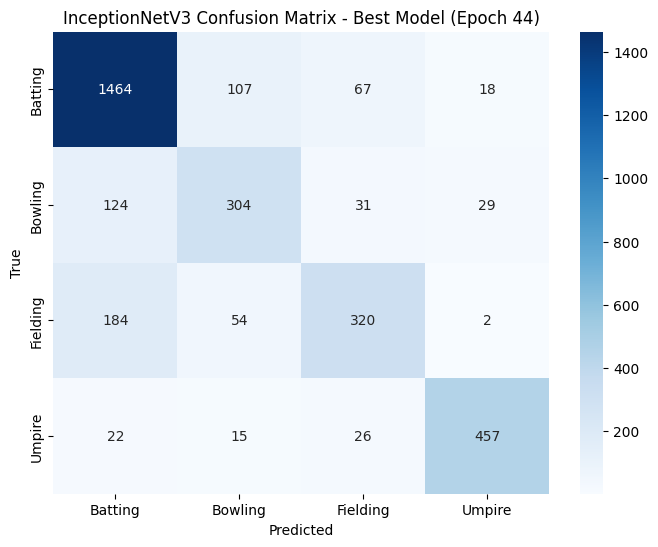

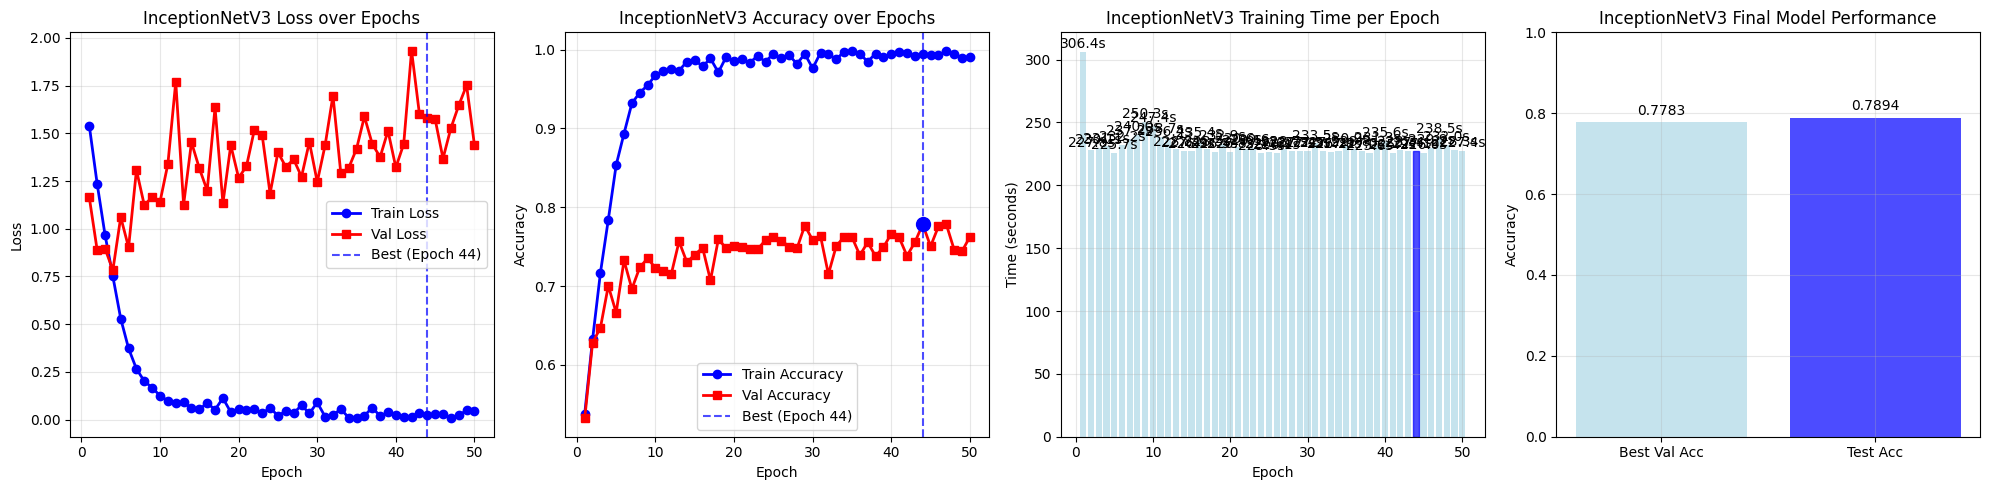


⏰ InceptionNetV3 Final Timing Summary:
│ Total Training: 11599.34s
│ Average per Epoch: 231.99s
│ Testing Time: 73.94s
│ Total Runtime: 11673.28s

💾 InceptionNetV3 Files saved:
│ best_inceptionnetv3_model.pth - Best validation accuracy model
│ inceptionnetv3_training_history.csv - Training metrics for later plotting


In [9]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - InceptionNetV3
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting InceptionNetV3 Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        # Resize images to 299x299 for InceptionV3
        imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Handle auxiliary output during training
        if model.aux_logits and model.training:
            outputs, aux_outputs = model(imgs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # Weight auxiliary loss by 0.4
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',  
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            # Resize images to 299x299 for InceptionV3
            imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best InceptionNetV3 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_inceptionnetv3_model.pth')
    print(f"\n💾 Best InceptionNetV3 model saved as 'best_inceptionnetv3_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('inceptionnetv3_training_history.csv', index=False)
print("\n💾 InceptionNetV3 training history saved to 'inceptionnetv3_training_history.csv'")

# Training Summary
print(f"\n🎉 InceptionNetV3 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best InceptionNetV3 Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best InceptionNetV3 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing InceptionNetV3", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        # Resize images to 299x299 for InceptionV3
        imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ InceptionNetV3 Testing completed in {test_time:.2f}s")
print("\n📋 InceptionNetV3 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 InceptionNetV3 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 InceptionNetV3 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"InceptionNetV3 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='blue', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("InceptionNetV3 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='blue', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='blue', s=100, zorder=5)
plt.legend()
plt.title("InceptionNetV3 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightblue', alpha=0.7)
bars[best_epoch-1].set_color('blue')
plt.title("InceptionNetV3 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightblue', 'blue']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("InceptionNetV3 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ InceptionNetV3 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 InceptionNetV3 Files saved:")
print(f"│ best_inceptionnetv3_model.pth - Best validation accuracy model")
print(f"│ inceptionnetv3_training_history.csv - Training metrics for later plotting")